### Question 1


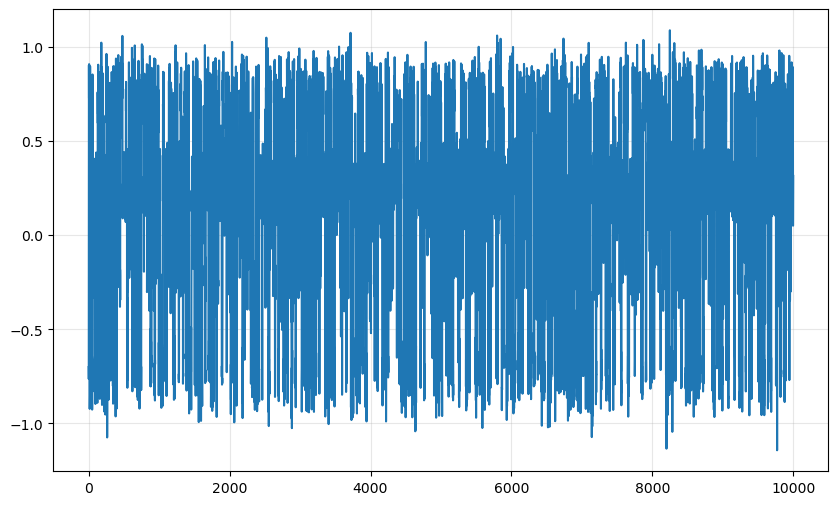

In [1]:
import numpy as np
import matplotlib.pyplot as plt

with open("traj-to-be-submitted.txt", "r") as f:
    lines = f.readlines()
data = list(map(float, lines))
data = np.array(data)
plt.figure(figsize=(10, 6))
plt.plot(data)
plt.grid(True, alpha=0.3)
plt.show()

### Question 2


In [2]:

bins = np.linspace(data.min(), data.max(), 50)
digitized = np.digitize(data, bins) - 1

### Quesiton 3


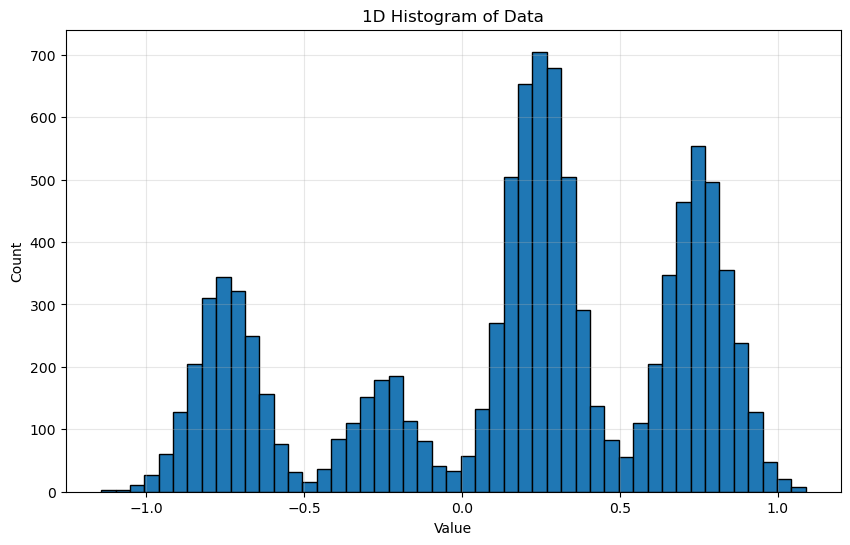

In [3]:
plt.figure(figsize=(10, 6))
plt.hist(data, bins=bins, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('1D Histogram of Data')
plt.grid(True, alpha=0.3)
plt.show()

For future use, let's label these macrostates A,B,C, and D from left to right.


### Question 4


In [4]:
# Calculate the count matrix
n_states = len(bins)
count_matrix = np.zeros((n_states, n_states))

for i in range(len(digitized) - 1):
    current_state = digitized[i]
    next_state = digitized[i + 1]
    count_matrix[current_state, next_state] += 1

print(f"Count matrix shape: {count_matrix.shape}")
print(f"Total transitions: {count_matrix.sum()}")

Count matrix shape: (50, 50)
Total transitions: 9999.0


### Question 5


In [5]:
row_sums = count_matrix.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1
transition_matrix = count_matrix / row_sums
row_sum_check = transition_matrix.sum(axis=1)

### Question 6

Based on the histogram we can see that we have 4 macrostates, meaning we have 3 slow processes connecting them, corresponding to the barriers between states.


### Question 7


In [6]:
eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)
eigenvalues = np.real(eigenvalues)
eigenvectors = np.real(eigenvectors)
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]
print("Top 5 eigenvalues:")
print(eigenvalues[:5])
tau = 1
# Ignore the trivial eigenvalue 1 for timescale calculation
timescales = -tau / np.log(np.abs(eigenvalues[1:]))
print("Top 5 timescales:")
print(timescales[:5])

Top 5 eigenvalues:
[1.         0.83783916 0.78509275 0.5321023  0.08697929]
Top 5 timescales:
[5.65198067 4.13302702 1.58498822 0.40948612 0.36328854]


### Question 8


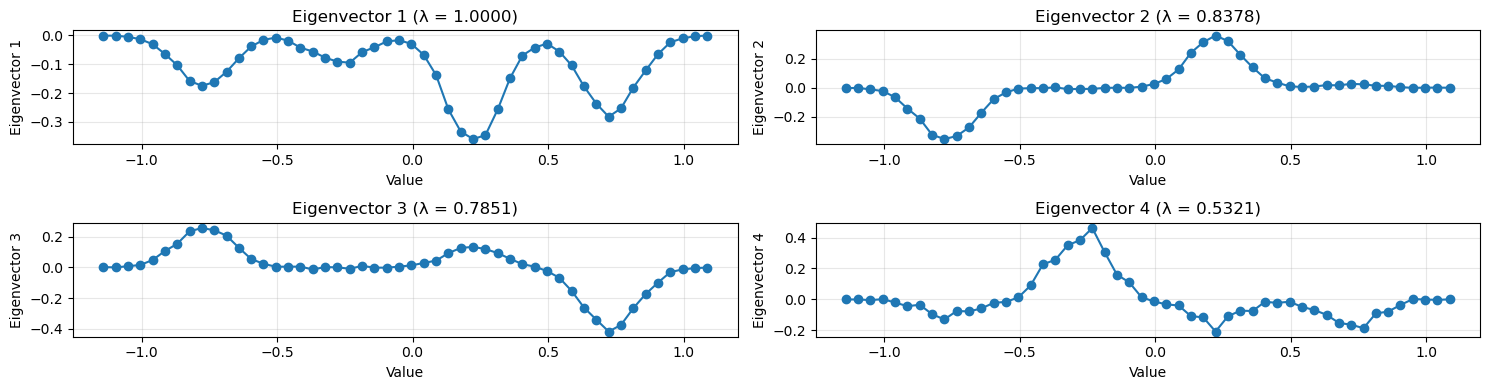

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 4))

for i in range(4):
    eigenvector_idx = i
    axes.flat[i].plot(bins, eigenvectors[:, eigenvector_idx], 'o-')
    axes.flat[i].set_xlabel('Value')
    axes.flat[i].set_ylabel(f'Eigenvector {eigenvector_idx + 1}')
    axes.flat[i].set_title(f'Eigenvector {eigenvector_idx + 1} (λ = {eigenvalues[eigenvector_idx]:.4f})')
    axes.flat[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

From these plots we can tell some things, such as the transition from positive values to negative being the rarest, due to that being the slowest process seen in Eigenvector 2. It seems the barrier around $x=0$ is the hardest to cross, and that the transition from state C to A is very uncommon.

Eigenvector 3 describes the transition from metastate C to D, being the second most uncommon transition. The reason there is a bump in metastate A seems to be to counter out the large dip in Eigenvector 2.

The last Eigenvector 4 has a sharp peak around metastate B, representing that molecules seemingly frequently gets to that state, but quickly leaves metastate B for metastate A. The reason it doesn't leave for metastate C or D is due to the barrier between A,B and C,D is hard to cross like stated about Eigenvector 2


### Question 9


/tmp/ipykernel_69121/3403723366.py:26: RuntimeWarning: divide by zero encountered in log
  timescales = -tau / np.log(np.abs(eigenvalues[1:]))


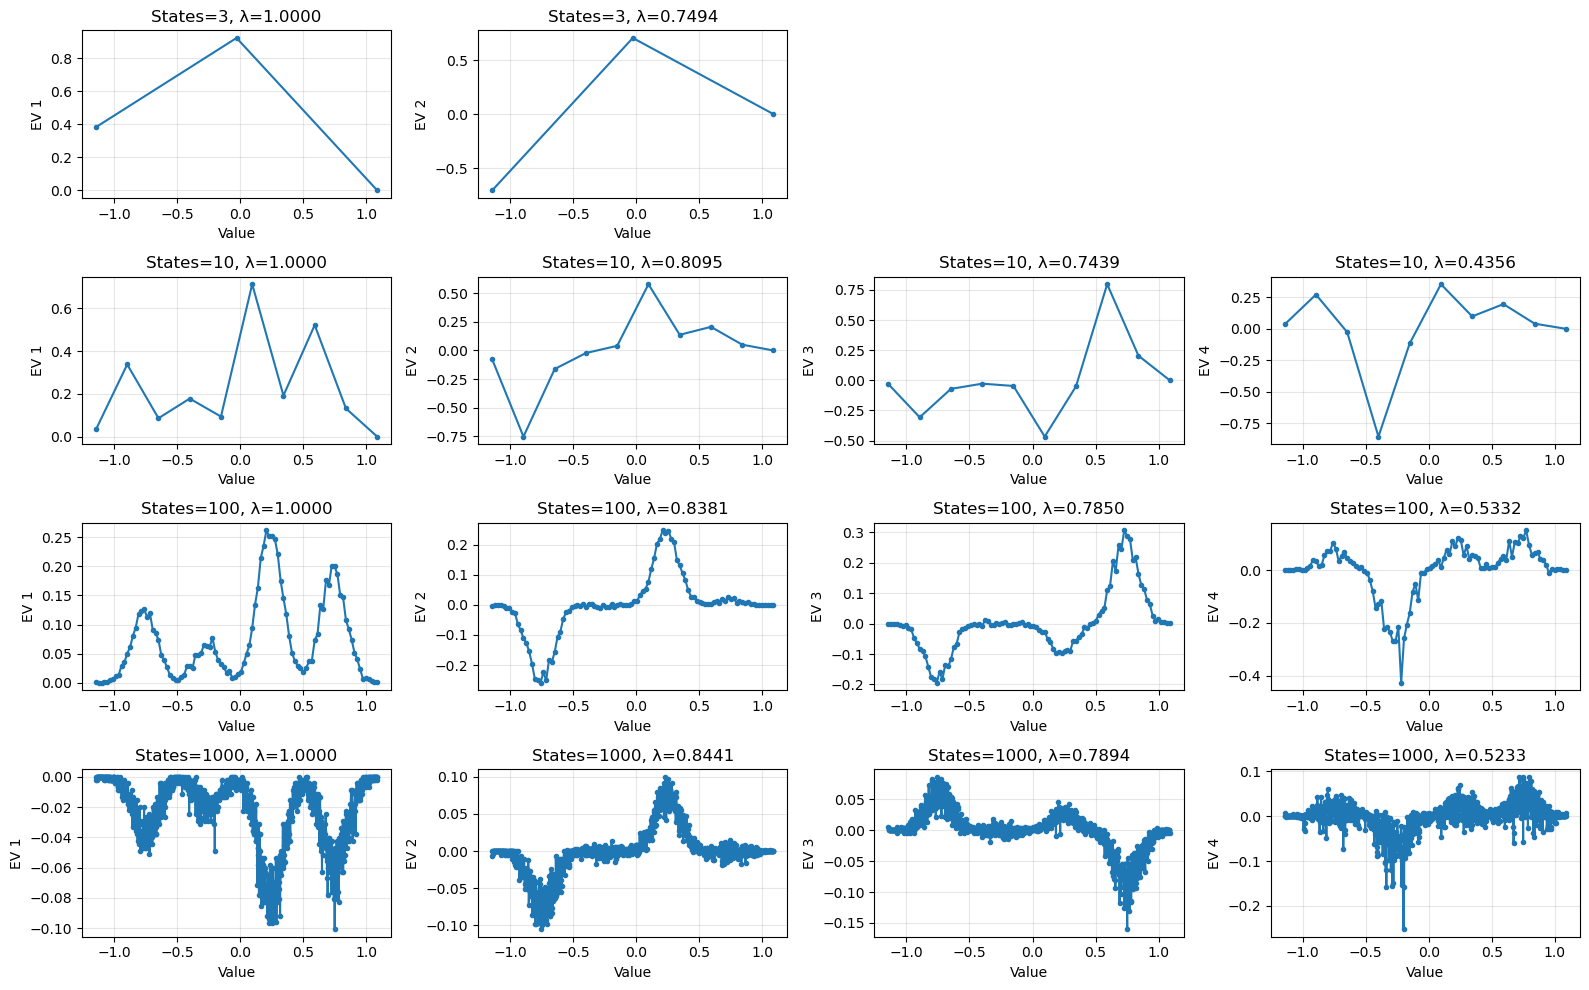

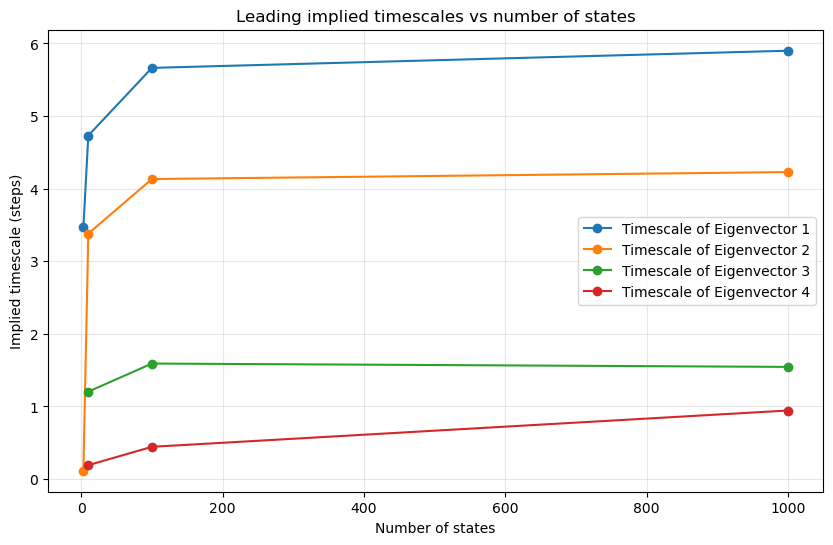

In [8]:
# Discretize the trajectory into multiple state counts and visualize leading eigenfunctions and timescales

state_counts = [3, 10, 100, 1000]
results = {}

def build_eigenvs_and_timescales(x, n_states):
    bins = np.linspace(x.min(), x.max(), n_states)
    digitized = np.digitize(x, bins) - 1
    count_matrix = np.zeros((n_states, n_states))
    for i in range(len(digitized) - 1):
        current_state = digitized[i]
        next_state = digitized[i + 1]
        count_matrix[current_state, next_state] += 1
    row_sums = count_matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    transition_matrix = count_matrix / row_sums
    row_sum_check = transition_matrix.sum(axis=1)

    eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)
    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    tau = 1
    timescales = -tau / np.log(np.abs(eigenvalues[1:]))

    return bins, transition_matrix, eigenvalues, eigenvectors, timescales

for n in state_counts:
    bins, transition_matrix, eigenvalues, eigenvectors, timescales = build_eigenvs_and_timescales(data, n)
    results[n] = {
        "bins": bins,
        "transition_matrix": transition_matrix,
        "eigenvalues": eigenvalues,
        "eigenvectors": eigenvectors,
        "timescales": timescales
    }

fig, axes = plt.subplots(len(state_counts), 4, figsize=(16, 10))
if len(state_counts) == 1:
    axes = np.array([axes])

for i, n in enumerate(state_counts):
    bins = results[n]["bins"]
    eigenvalues = results[n]["eigenvalues"]
    eigenvectors = results[n]["eigenvectors"]
    nontrivial_available = min(4, n - 1)

    # Plot eigenvectors <= 4
    for j in range(4):
        ax = axes[i, j]
        if j < nontrivial_available:
            ev_idx = j
            ax.plot(bins, eigenvectors[:, ev_idx], 'o-', markersize=3)
            ax.set_xlabel('Value')
            ax.set_ylabel(f'EV {ev_idx + 1}')
            ax.set_title(f'States={n}, λ={eigenvalues[ev_idx]:.4f}')
            ax.grid(True, alpha=0.3)
        else:
            ax.axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for k in range(4):
    ys = []
    for n in state_counts:
        xs = results[n]["timescales"]
        ys.append(xs[k] if k < len(xs) else np.nan)
    plt.plot(state_counts, ys, 'o-', label=f'Timescale of Eigenvector {k + 1}')

plt.xlabel('Number of states')
plt.ylabel('Implied timescale (steps)')
plt.title('Leading implied timescales vs number of states')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

We can clearly see that increasing the number of states too much makes the plots more busy, and less readable.

We also see the timescale of Eigenvector 2 which contains the slow process increase based on the number of states up to a point around 100 bins, where it flattens out.

I am not sure why we see this flattening, the best guess is that we are subdividing the metastates into smaller states, which don't make any actual difference in terms of transition speed between states. We see a convergence approaching the actual timescales.
